In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.linalg import expm, logm

from edesign import *
from utility import *
from models import *
from edesign import *
from display import *

#setup autoreload
%load_ext autoreload
%autoreload 2

# Finding cliffords

In [4]:
# def X(qid):
#     return [('Gxpi2', qid)]

# def Z(qid):
#     return [('Gzpi2', qid)]

# def Y(qid):
#     return Z(qid) + X(qid) + Z(qid)*3


# def compile_clifford_1q_to_pygsti(cstring, qid):
#     chars_in_cstring = list(cstring)
#     circuit = []
#     for c in chars_in_cstring:
#         if c == 'I':
#             circuit += ([[]])
#         elif c == 'X':
#             circuit += (X(qid))
#         elif c == 'Y':
#             circuit += (Y(qid))
#         elif c == 'Z':
#             circuit += (Z(qid))
#         else:
#             raise ValueError('Invalid character in clifford string')
#     return circuit



In [6]:
from itertools import product

def compile_pauli_string_1q_to_unitary(cstring):
    x = expm(-1j * np.pi/4 * SigX)
    y = expm(-1j * np.pi/4 * SigY)
    z = expm(-1j * np.pi/4 * SigZ)
    chars_in_cstring = list(cstring)
    unitary = np.eye(2)
    for c in chars_in_cstring:
        if c == 'I':
            pass
        elif c == 'X':
            unitary = x@unitary
        elif c == 'Y':
            unitary = y@unitary
        elif c == 'Z':
            unitary = z@unitary
        else:
            raise ValueError('Invalid character in clifford string')
    return unitary


def product_upto(iterable, max_length):
  """
  Generate all possible combinations of elements from the given iterable,
  with the length of each combination less than or equal to max_length.

  Args:
    iterable: An iterable from which to generate combinations.
    max_length: The maximum length of the combinations.

  Returns:
    A list of tuples representing the combinations.
  """
  result = []
  for length in range(1, max_length + 1):
    for combination in product(iterable, repeat=length):
      result.append(combination)
  return result

def product_upto(iterable, max_length):
  """
  Generate all possible combinations of elements from the given iterable,
  with the length of each combination less than or equal to max_length.

  Args:
    iterable: An iterable from which to generate combinations.
    max_length: The maximum length of the combinations.

  Returns:
    A list of tuples representing the combinations.
  """
  result = []
  for length in range(1, max_length + 1):
    for combination in product(iterable, repeat=length):
      result.append(combination)
  return result


def check_if_similar_clifford(u1, u2):
    # check if u1 and u2 are similar up to a global phase
    if np.allclose(u1, u2):
        return True
    elif np.allclose(u1, -u2):
        return True
    elif np.allclose(u1, 1j*u2):
        return True
    elif np.allclose(u1, -1j*u2):
        return True
    else:
        return False


def is_similar_in_list(string, list_of_strings):
    u = compile_pauli_string_1q_to_unitary(string)
    for s in list_of_strings:
        v = compile_pauli_string_1q_to_unitary(s)
        if check_if_similar_clifford(u, v):
            return True
    return False


def find_clifford_group_representation():
    all_strings = [('I', )] + product_upto('XYZ', 6)

    # now find a the unique strings until you have 24
    unique_strings = []
    for s in all_strings:
        if not is_similar_in_list(s, unique_strings):
            unique_strings.append(s)
        if len(unique_strings) == 24:
            break
    # convert the strings to a list of strings
    unique_strings = [''.join(s) for s in unique_strings]
    return unique_strings


In [8]:
clifford_group = find_clifford_group_representation()
clifford_group

['I',
 'X',
 'Y',
 'Z',
 'XX',
 'XY',
 'XZ',
 'YY',
 'YZ',
 'ZX',
 'ZZ',
 'XXX',
 'XXY',
 'XXZ',
 'XYY',
 'XZX',
 'XZZ',
 'YYY',
 'YYZ',
 'ZZZ',
 'XXXZ',
 'XXZX',
 'XYYZ',
 'XZZZ']

# Calculating cartan phases and frames (derivatives)

In [9]:
def compile_clifford_folded_cz_unitary(cz_unitary, k1_before, k2_before, k1_after, k2_after):
    # k1_before, k2_before, k1_after, k2_after are the clifford strings before and after the CZ gate
    # returns the circuit for the CZ gate
    u1 = compile_pauli_string_1q_to_unitary(k1_before)
    u2 = compile_pauli_string_1q_to_unitary(k2_before)
    U_before = np.kron(u1, u2)
    u1_after = compile_pauli_string_1q_to_unitary(k1_after)
    u2_after = compile_pauli_string_1q_to_unitary(k2_after)
    U_after = np.kron(u1_after, u2_after)
    return U_after @ cz_unitary @ U_before

In [10]:
x = 0.01*np.random.randn(15)
model = UnitaryGateSetModel_CZOnly()
cz_noisy = model.gate('CZ', x)
cz_target = model.gate('CZ', np.zeros(15))

In [11]:


# def calc_cartan_coefs(U, basis=cartan_basis):
#     cartan_coefs = np.array([ np.trace(U @ B) for B in basis])
#     return cartan_coefs

# def calc_cartan_frame(U, basis=cartan_basis):
#     # calculate the cartan frame of the unitary U
#     # basis is the cartan basis
#     # returns the cartan frame
#     log_U = logm(U)
#     cartan_frame = np.array([ np.trace(log_U @ B) for B in basis])
#     # check that the frame is imaginary
#     assert np.allclose(np.real(cartan_frame), 0)
#     return np.imag(cartan_frame)


# something the AI came up with:
    # U = U/np.linalg.det(U)**(1/4)
    # U = U/np.linalg.norm(U)
    # U = np.linalg.inv(U)
    # cartan_frame = []
    # for B in basis:
    #     cartan_frame.append(np.trace(U @ B))
    # return cartan_frame

In [12]:
cartan_basis = [
    np.diag([1, -1, 0, 0]),
    np.diag([0, 1, -1, 0]), 
    np.diag([0, 0, 1, -1]),
]

def calc_cartan_phases(U, basis=cartan_basis):
    log_U = logm(U)
    cartan_phases = np.array([ np.trace(log_U @ B) for B in basis])
    # check that the frame is imaginary
    assert np.allclose(np.real(cartan_phases), 0)
    return np.imag(cartan_phases)

def calc_cartan_jacobian(U, model, epsilon=1e-6):
    basis = model.cartan_basis
    num_params = model.num_params
    jacobian = np.zeros((len(basis), num_params))
    for i in range(num_params):
        X_i = model.lie_basis(i)
        U_plus = expm(1j*epsilon*X_i) @ U
        U_minus = expm(-1j*epsilon*X_i) @ U
        phases_plus = calc_cartan_phases(U_plus, basis)
        phases_minus = calc_cartan_phases(U_minus, basis)
        jacobian[:, i] = angular_difference(phases_plus, phases_minus)/(2*epsilon)
        if np.any(jacobian[:, i] > 1e5):
            print('Warning: large jacobian value')
            print(phases_plus)
    return jacobian

In [13]:
angular_difference

<function utility.angular_difference(phi1, phi2, domain=6.283185307179586)>

In [14]:
print(calc_cartan_phases(cz_noisy), calc_cartan_phases(cz_target))

[-0.01320154  0.00534105 -3.13707825] [ 0.          0.         -3.14159265]


In [15]:
U_folded = compile_clifford_folded_cz_unitary(cz_target, 'XX', 'Y', 'I', 'I')

In [16]:
calc_cartan_jacobian(U_folded, model)

[ 1.57079533e+00 -7.85397663e-01  1.57218683e-12]
[-1.57079533e+00  7.85397663e-01  1.56941127e-12]
[ 1.57079744e+00 -7.85400940e-01  2.22144147e-06]
[ 1.57079744e+00 -7.85397608e-01 -3.33066907e-16]
[-1.57079522e+00  7.85397608e-01  2.22144147e-06]
[ 1.57079522e+00 -7.85399829e-01  2.22144147e-06]
[-1.57079533e+00  7.85397663e-01  1.57029945e-12]
[-1.57079533e+00  7.85397663e-01 -1.57129865e-12]


array([[-1.57079533e+06, -2.22044605e-10,  1.57079533e+06,
        -1.11072073e+00, -1.57079633e+06,  1.57079522e+06,
        -1.11072073e+00, -1.57079522e+06,  1.57079522e+06,
         1.11072073e+00, -1.57079522e+06,  0.00000000e+00,
         1.57079533e+06,  4.44089210e-10,  1.57079533e+06],
       [ 7.85397663e+05,  0.00000000e+00, -7.85397663e+05,
         1.66608110e+00,  7.85398163e+05,  7.85397608e+05,
         5.55360366e-01, -7.85397608e+05, -7.85397608e+05,
        -1.66608110e+00,  7.85399829e+05, -2.22044605e-10,
        -7.85397663e+05, -1.57079633e+00, -7.85397663e+05],
       [-1.57229785e-06,  8.88178420e-10, -1.56963331e-06,
         2.22044605e-10, -6.66133815e-10,  2.22044605e-10,
         2.22144147e+00,  0.00000000e+00, -2.22144147e+00,
         0.00000000e+00, -2.22144147e+00, -2.22044605e-10,
        -1.57029945e-06,  3.14159265e+00,  1.57163171e-06]])

In [17]:
calc_cartan_jacobian(cz_target, model)

array([[ 0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -2.],
       [ 0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,  0.,
         0.,  0.],
       [ 0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.]])

In [18]:
calc_cartan_jacobian(cz_noisy, model)

array([[-6.87195234e-03, -2.65051892e-03, -1.99991217e+00,
         7.22158866e-03, -5.89519855e-03,  1.02126492e-02,
        -4.66769401e-03,  1.13634024e-02,  1.99885208e-02,
        -1.21097754e-03,  1.02067423e-02,  8.43216608e-05,
        -6.71068068e-03, -2.67755196e-03, -1.99994103e+00],
       [ 2.16290963e-02,  1.62810911e-02,  1.99981094e+00,
        -4.57620120e-03,  7.10073378e-03,  9.82561255e-03,
         7.19803817e-03,  1.02807720e-02, -9.61008384e-03,
         7.08192505e-03,  1.14916954e-02, -1.99992578e+00,
        -1.48844790e-02, -1.35985208e-02,  1.85560234e-04],
       [-3.65222685e-02, -2.98798719e-02, -1.99960021e+00,
        -7.36264627e-03, -5.82264303e-03,  1.00624356e-02,
         4.62346872e-03, -1.14294776e-02,  1.97003889e-02,
        -1.17420873e-03, -1.05135567e-02,  2.51636489e-05,
         3.65577939e-02,  2.97978964e-02,  1.99962907e+00]])

In [19]:
def calculate_frame_derivative(U, model):
    # calculate the derivative of the cartan frame with respect to the parameters
    # param0 is the parameters of the unitary
    basis = model.cartan_basis
    num_params = model.num_params
    jacobian = np.zeros((len(basis), num_params), dtype=complex)
    log_U = logm(U)
    for i in range(num_params):
        dU = model.lie_basis(i)
        for j, B in enumerate(basis):
            jacobian[j, i] = np.trace(log_U @ dU @ B)
    assert np.allclose(np.real(jacobian), 0, atol=1e-5), print(np.max(np.real(jacobian)))   
    return np.imag(jacobian)

In [20]:
from tqdm import tqdm

In [21]:
def make_all_cz_clifford_pairs():
    all_cliffords = find_clifford_group_representation()
    all_clifford_folds = []
    for k1 in all_cliffords:
        for k2 in all_cliffords:
            U_folded = compile_clifford_folded_cz_unitary(cz_noisy, k1, k2, 'I', 'I')
            all_clifford_folds.append((k1, k2, U_folded))
    return all_clifford_folds

In [22]:
clifford_cz_pairs = make_all_cz_clifford_pairs()

In [23]:
all_frames = {}
for k1, k2, U_folded in tqdm(clifford_cz_pairs):
    frame = calc_cartan_jacobian(U_folded, model)
    all_frames[(k1, k2)] = frame

  0%|          | 0/576 [00:00<?, ?it/s]

100%|██████████| 576/576 [00:28<00:00, 19.93it/s]


In [24]:
def calc_frame_potential(frame):
    fpot = 0
    for row1 in frame:
        for row2 in frame:
            fpot += np.abs(np.dot(row1.conj().T, row2))**2
    return fpot

def stack_frame_dict(frame_dict):
    frames = []
    for k, frame in frame_dict.items():
        frames.append(frame)
    return np.vstack(frames)

def find_optimal_frame_set(starting_frame_dict, all_frames, max_frames=5):
    # starting_frame is the initial frame
    # all_frames is a dictionary of all the frames of the folded CZ gates
    # max_frames is the maximum number of frames to use
    # returns the optimal set of frames
    optimal_frame_dict = starting_frame_dict.copy()
    for i in tqdm(range(max_frames-len(starting_frame_dict))):
        min_potential = np.inf
        best_frame = None
        best_frame_key = None
        old_frames = stack_frame_dict(optimal_frame_dict)
        for k, frame in all_frames.items():
            if k in optimal_frame_dict:
                continue
            new_frames = np.vstack([old_frames, frame])
            potential_with_new_frame = calc_frame_potential(new_frames)
            if potential_with_new_frame < min_potential:
                min_potential = potential_with_new_frame
                best_frame = frame
                best_frame_key = k
        if best_frame is not None:
            optimal_frame_dict[best_frame_key] = best_frame
    return optimal_frame_dict


In [25]:
len(all_frames)

576

In [26]:
starting_interleaving_pair = ('XX', 'Y')
starting_frame_dict = {}
starting_frame_dict[starting_interleaving_pair] = all_frames[starting_interleaving_pair]
optimal_frame_dict = find_optimal_frame_set(starting_frame_dict, all_frames)

100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


In [27]:
optimal_frame_dict

{('XX',
  'Y'): array([[ 1.02040389e+00, -2.52544461e-02, -9.77145161e-01,
         -1.12238079e+00, -1.13406280e+00, -1.09990888e+00,
          1.08766332e+00,  1.11582145e+00, -1.12773908e+00,
         -1.10237706e+00,  1.11448616e+00,  5.95753935e-03,
         -9.89788591e-01, -1.26342115e-02, -1.01201943e+00],
        [-5.14892310e-01,  8.53466231e-03,  4.85818994e-01,
          1.64909306e+00,  2.79442390e+00, -5.53602455e-01,
         -5.42861955e-01,  5.57040210e-01,  5.57706004e-01,
          1.69117510e+00,  1.65593067e+00,  1.38938314e-02,
          4.78894016e-01,  1.58504930e+00,  4.97283708e-01],
        [-1.45860586e-02, -9.25749788e-03, -9.11133391e-04,
          9.12843268e-03, -2.20458586e+00, -3.00060850e-02,
         -2.20115865e+00,  1.74456287e-02, -2.21111314e+00,
         -2.07602682e-02, -2.21907255e+00, -1.23758470e-02,
         -3.94695543e-03, -3.11477962e+00,  3.57854044e-02]]),
 ('ZZZ',
  'I'): array([[-6.24102392e-03, -2.43713871e-03, -1.99972181e+00,
    

In [28]:
optimal_frame_dict.keys()

dict_keys([('XX', 'Y'), ('ZZZ', 'I'), ('ZZ', 'XZZZ'), ('I', 'XYYZ'), ('I', 'XY')])

In [29]:
total_jacobian = stack_frame_dict(optimal_frame_dict)
np.linalg.matrix_rank(total_jacobian)

15

# check the stability of the identified experiment

In [30]:
optimal_germs = [
    ['X1', 'X1', 'Y2', 'CZ'],
    ['Z1', 'Z1', 'Z1', 'Z2', 'CZ'],
    ['X1', 'Y1', 'Y1', 'Z1', 'CZ'],
    ['X1', 'X1', 'X1', 'Z1', 'X2', 'X2', 'X2', 'Z2', 'CZ'],
    ['Z1', 'Z1', 'X2', 'Z2', 'CZ'],
]
depths = [i+1 for i in range(100)]

edesign = RPEDesign(UnitaryGateSetModel_CZOnly(), optimal_germs, depths)

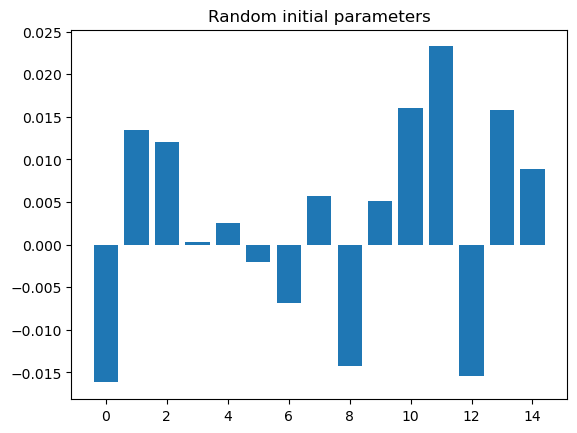

<Figure size 640x480 with 0 Axes>

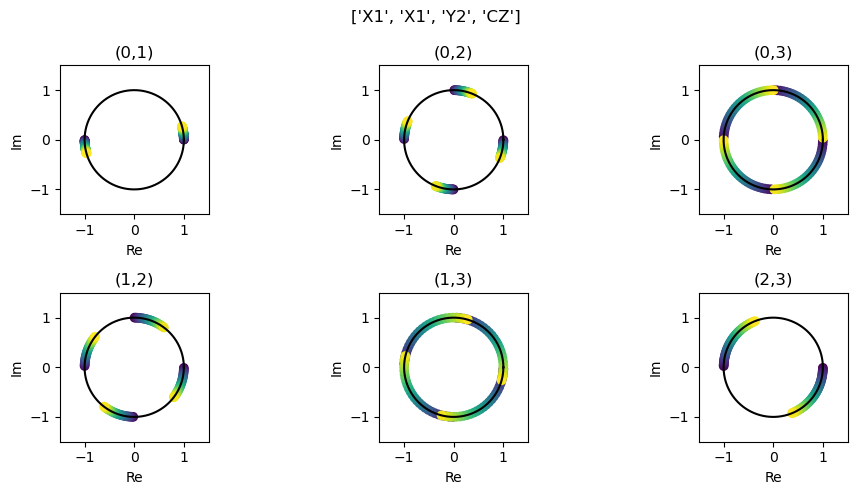

<Figure size 640x480 with 0 Axes>

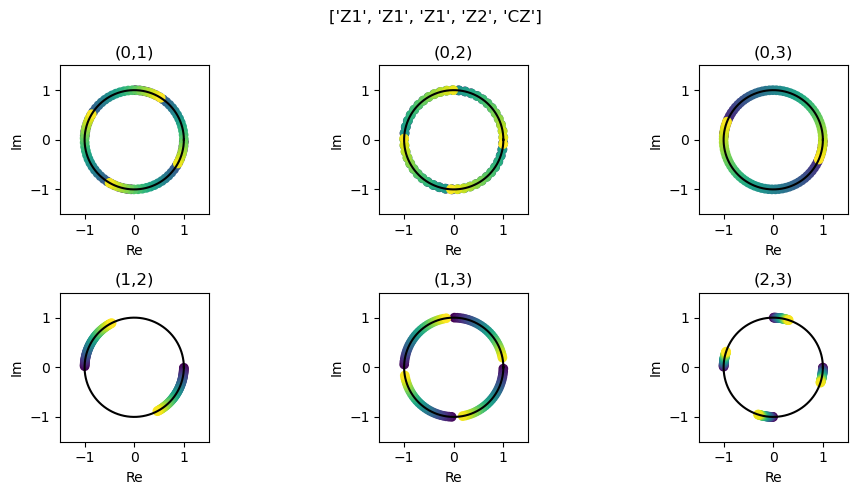

<Figure size 640x480 with 0 Axes>

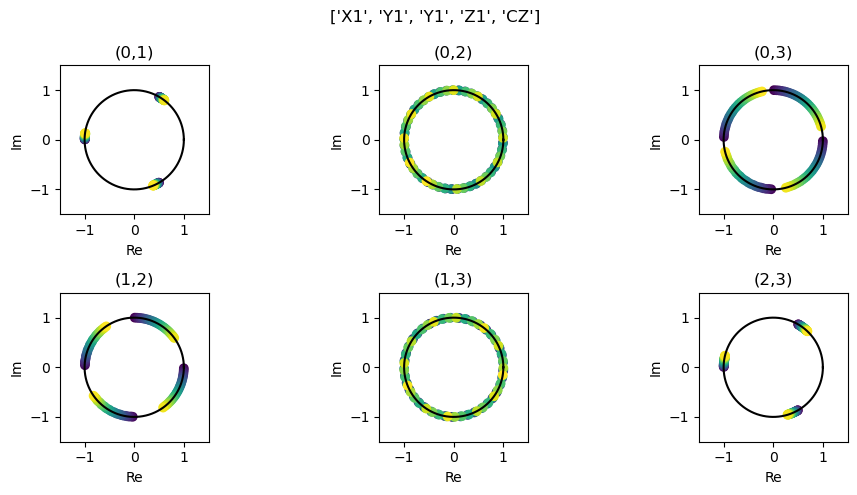

<Figure size 640x480 with 0 Axes>

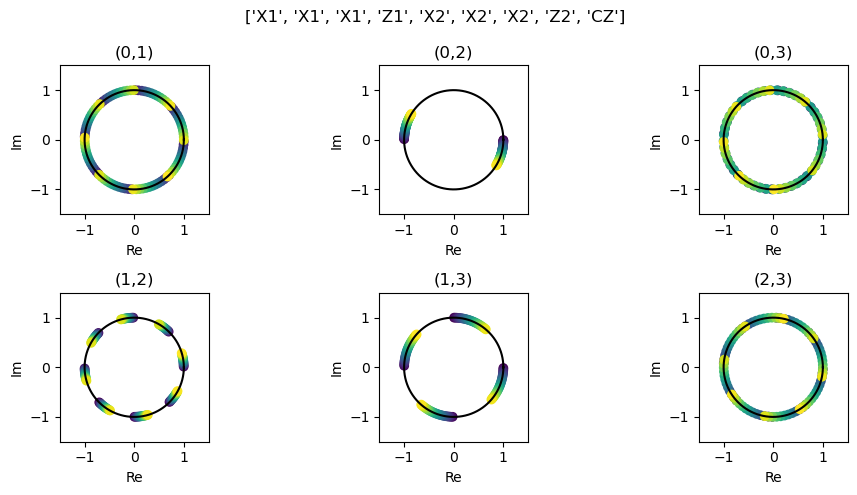

<Figure size 640x480 with 0 Axes>

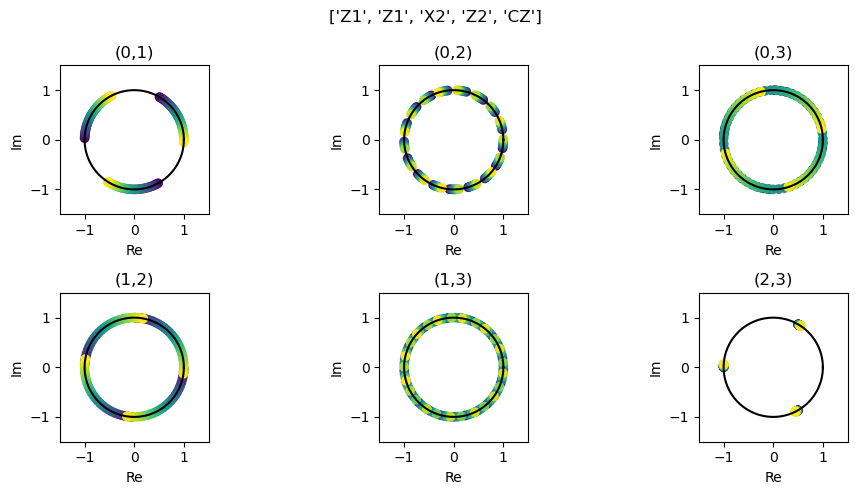

<Figure size 640x480 with 0 Axes>

In [31]:
x = 0.01*np.random.randn(15)
plt.bar(range(15), x)
plt.title('Random initial parameters')
plt.show()
plt.figure()
for germ in optimal_germs:
    plot_cartan_signals(edesign, germ, x)
    plt.show()
    plt.figure()